# Get Data

In [1]:
#!pip install kagglehub

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
!nvidia-smi

Fri Feb 28 17:28:34 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 5000                Off | 00000000:1B:00.0 Off |                  Off |
| 33%   27C    P8              10W / 230W |      6MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import pathlib
import kagglehub
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# Import specific callback functions from Keras for model training callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Input, Rescaling, Conv3D, MaxPooling3D, Activation, BatchNormalization, Dropout, Flatten, Dense, RandomFlip, RandomRotation)
from tensorflow.keras.layers import GRU, Conv2D, TimeDistributed, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt


In [4]:
path = kagglehub.dataset_download("kk20krishna/gesture-recognition-dataset")

100%|██████████| 1.60G/1.60G [01:32<00:00, 18.6MB/s]

Extracting model files...


In [15]:
project_data_path = pathlib.Path(path) / 'Project_data'

print("Path to project data:", project_data_path)

Path to project data: /home/.cache/kagglehub/datasets/kk20krishna/gesture-recognition-dataset/versions/1/Project_data


In [16]:
print('Files in project_data_path:')
for folder in project_data_path.iterdir():
    if folder.is_file():
        print(folder.name)

print('\nFolders in project_data_path:')
for folder in project_data_path.iterdir():
    if folder.is_dir():
        print(folder.name,
              ':',
              len(list(subfolder for subfolder in folder.iterdir())), 'folders',
              'and',
              len(list(folder.glob('*/*'))), 'files')


Files in project_data_path:
train.csv
val.csv

Folders in project_data_path:
train : 663 folders and 19890 files
val : 100 folders and 3000 files


# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [17]:
import numpy as np
import os
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [18]:
np.random.seed(44)
import random as rn
rn.seed(44)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(44)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [19]:
train_doc_path = project_data_path/'train.csv'
val_doc_path = project_data_path/'val.csv'
train_data_path = project_data_path/'train'
val_data_path = project_data_path/'val'

In [20]:
def read_doc_file(file):
    """
    Reads a .doc file and returns its content as a list of lists, where each line is split by a semicolon.

    Parameters:
    file (str): Path to the .doc file.

    Returns:
    list: A list of lists containing parsed lines from the file.
    """
    train_list = []
    with open(file, 'r') as file:
        # Skip header if exists
        # next(file, None)
        for line in file:
            train_list.append(line.strip().split(';'))
    return train_list

train_folders_data = read_doc_file(train_doc_path)
print(len(train_folders_data))

val_folders_data = read_doc_file(val_doc_path)
print(len(val_folders_data))

663
100


In [21]:
# Analyze class distribution

gestures = [folder[2] for folder in train_folders_data]
gesture, counts = np.unique(gestures, return_counts=True)

for i in range(len(gesture)):
    print(counts[i], gesture[i])

print("\n")

gestures = [folder[2] for folder in val_folders_data]
gesture, counts = np.unique(gestures, return_counts=True)

for i in range(len(gesture)):
    print(counts[i], gesture[i])

136 0
137 1
130 2
137 3
123 4


18 0
23 1
22 2
21 3
16 4


In [22]:
def print_images_in_folder(folder_paths, frame_rate=None, frame_size=None):
    """
    Displays images from a given folder in a grid layout using Matplotlib.

    Parameters:
    folder_paths (Path): Path to the folder containing images.
    frame_rate (int, optional): If provided, selects images at intervals based on the given frame rate.
    frame_size (tuple, optional): If provided, resizes images to the specified (width, height).

    The function arranges the images in a grid of 3 rows and 10 columns, ensuring the order of images is preserved.
    """

    # Get image paths
    image_paths = sorted(list(folder_paths.iterdir())) # It is important to sort since the order of the images is important for gesture recognition

    # Frame rate
    if frame_rate is not None:
        frame_slice = len(image_paths) // frame_rate  # Step size for slicing
        image_paths = image_paths[::frame_slice]

    # Define grid size
    rows, cols = 3, 10
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))  # Adjust figure size

    # Frame rate
    #frame_slice = len(video_data) // frame_rate  # Step size for slicing

    # Loop through images and plot them
    for idx, image_path in enumerate(image_paths):
        img = cv2.imread(str(image_path))  # Read image using OpenCV
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            # Resize
            if frame_size is not None: img_rgb = cv2.resize(img_rgb, frame_size)
            row, col = divmod(idx, cols)  # Calculate row and column indices
            axes[row, col].imshow(img_rgb)
            axes[row, col].axis("off")  # Hide axis labels
        else:
            print(f"Could not read image: {image_path}")

    # Hide unused subplots
    total_images = len(image_paths)
    total_slots = rows * cols  # Total number of subplots in the grid

    if total_images < total_slots:
        for idx in range(total_images, total_slots):
            row, col = divmod(idx, cols)
            fig.delaxes(axes[row, col])  # Remove unused axes

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

In [23]:
# Select one training folder
prt_folder_name = [folder[0] for folder in train_folders_data][0] # select only one folder
prt_folder_path = train_data_path / prt_folder_name

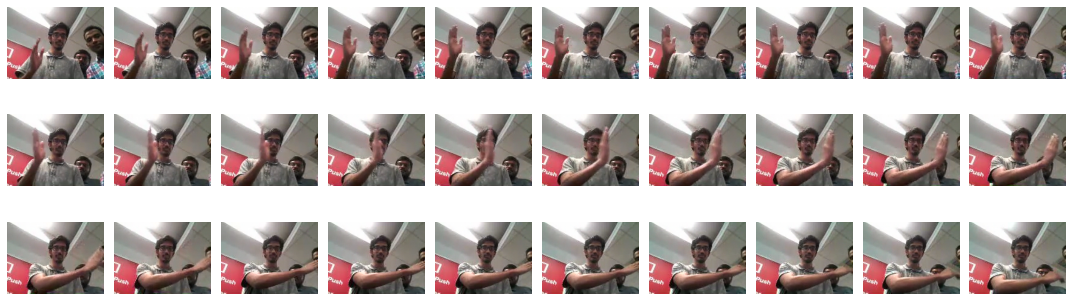

In [24]:
# Pring Images in Folder as-is
print_images_in_folder(prt_folder_path)

In [ ]:
# Print Images in Folder with frame rate 15
print_images_in_folder(prt_folder_path, frame_rate=15)

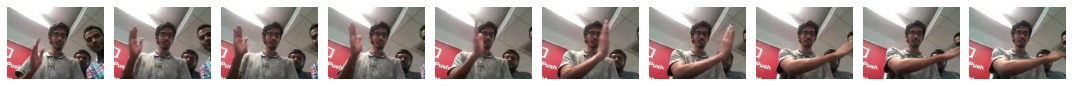

In [26]:
# Print Images in Folder with frame rate 10
print_images_in_folder(prt_folder_path, frame_rate=10)

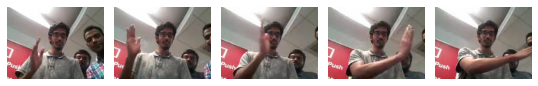

In [27]:
# Print Images in Folder with frame rate 5
print_images_in_folder(prt_folder_path, frame_rate=5)

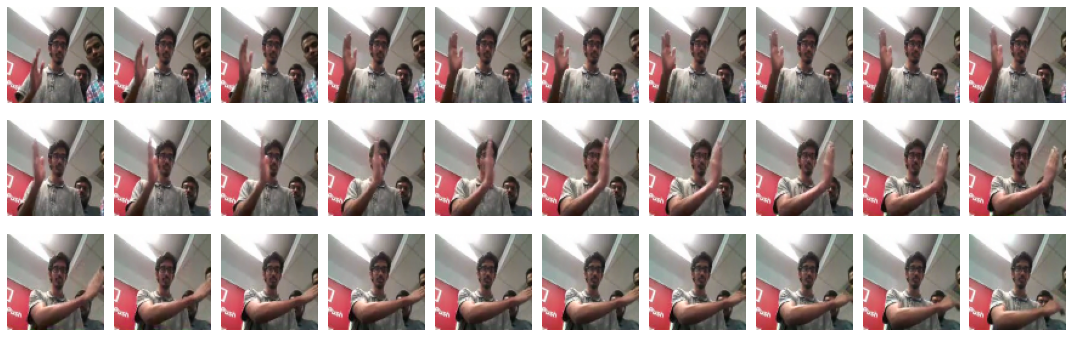

In [ ]:
# Print Images in Folder after resize to 80x80
print_images_in_folder(prt_folder_path, frame_size=(80,80))

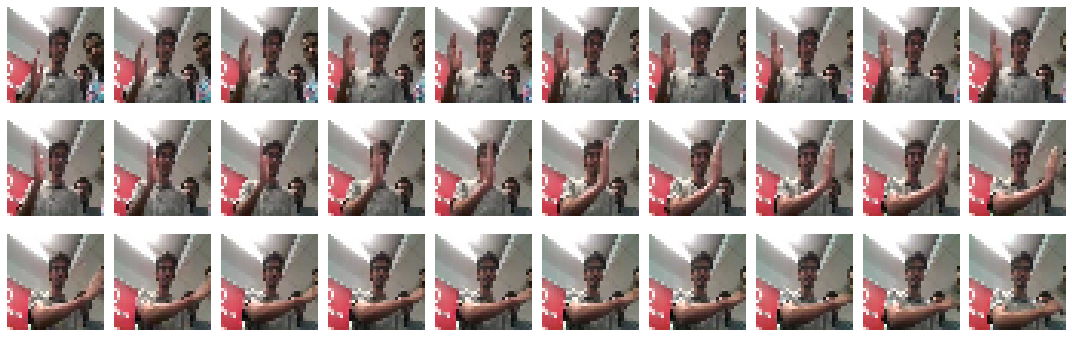

In [29]:
# Print Images in Folder after resize to 32x32
print_images_in_folder(prt_folder_path, frame_size=(32,32))

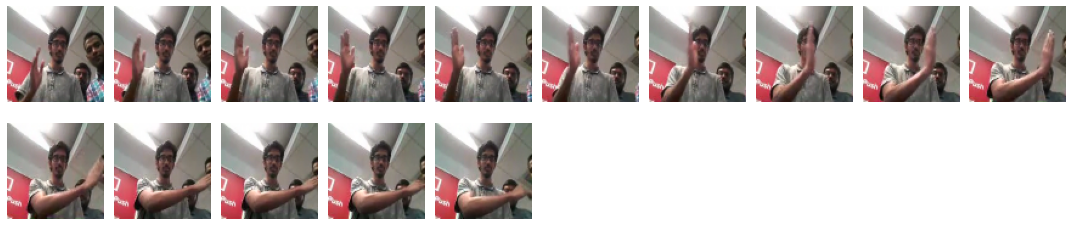

In [30]:
# Print Images with reduced frame rate and size
print_images_in_folder(prt_folder_path, frame_rate=15, frame_size=(80,80))

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [31]:
def generator(source_path, folder_list, batch_size, frame_rate, frame_size, verbose=-1):
    """
    Generator function to yield batches of video frames.

    Parameters:
    source_path (Path): Base directory containing video folders.
    folder_list (list): List of folder names containing videos.
    batch_size (int): Number of videos per batch.
    frame_rate (int, optional): Frame rate for video. 10, 20, 30, etc.
    frame_size (tuple, optional): Target size of frames (width, height).
    verbose (int, optional): Verbosity level (0=none, 1=basic, 2=detailed, 3=debug). Default is 0.

    Yields:
    np.ndarray: Batch of processed video frames.
    """

    # Determine the number of batches
    num_batches = (len(folder_list) + batch_size - 1) // batch_size

    if verbose>=0: # Logging level 0
      print('\n---Starting Generator---', '\n',
            'Source Path = ', source_path, '\n',
            '# of videos', len(folder_list), ' | ',
            'batch size =', batch_size, ' | ',
            '# of batches', num_batches, ' | ',
            'frame rate =', frame_rate, ' | ',
            'frame size =', frame_size, ' | ',
            'verbose =', verbose, ' | ',
            '\n------------------------', '\n',
            )

    while True:
        # Shuffle folder list to randomize batch processing
        folder_list_rand = np.random.permutation(folder_list)

        if verbose>=1: print("Generating new set of number of batches:", num_batches) # Logging level 1

        # Iterate over batches
        for batch in range(num_batches):

            # Determine the actual batch size for this iteration
            remaining_batch_size = len(folder_list_rand) - (batch * batch_size)
            create_batch_size = min(remaining_batch_size, batch_size)

            if verbose>=1: print("  Processing Batch#", batch, " remaining_batch_size: ", remaining_batch_size, " create_batch_size: ", create_batch_size) # Logging level 1

            # Process each video in the batch
            batch_data = []
            batch_labels = []
            for video in range(create_batch_size): # iterate over the batch_size
                video_idx = video + (batch*batch_size)
                video_path = source_path/folder_list_rand[video_idx][0]
                if verbose>=2: print("    Processing folder#", video_idx, " : ",
                                     len([file for file in video_path.iterdir()]), " files",
                                     " : ", folder_list_rand[video_idx][0]) # Logging level 2

                # Process frames in the video
                video_data = []
                for frame_idx, frame_path in enumerate(sorted([file for file in video_path.iterdir()])):
                    if verbose>=3: print("      Processing Frame: ", frame_path) # Logging level 3

                    frame = cv2.imread(str(frame_path))  # OpenCV reads images as (height, width, channels)
                    if frame is None:
                      print("Error!!! reading image at path: ", frame_path)
                      break

                    # Resize and store the frame
                    frame = cv2.resize(frame, frame_size) # but cv2.resize(frame, frame_size) expects (width, height)

                    # Collect frames for video
                    video_data.append(frame)

                # Frame rate
                frame_slice = len(video_data) // frame_rate  # Step size for slicing
                video_data = video_data[::frame_slice]

                #Collect videos for batch
                batch_data.append(video_data)
                batch_labels.append(int(folder_list_rand[video_idx][2]))

            # one-hot encode the labels
            #num_classes = len(set(label[2] for label in folder_list))  # Calculate unique class labels
            num_classes = 5
            batch_labels = to_categorical(batch_labels, num_classes=num_classes)

            # Yield the batch as a NumPy array
            yield np.array(batch_data, dtype=np.float32), np.array(batch_labels)


In [32]:
# Test generator

temp_batch_size = 32

# Initialize the generator
temp_data_generator = generator(train_data_path, train_folders_data[:200], batch_size=temp_batch_size, frame_rate=10, frame_size=(64, 64), verbose=1)

num_temp_sequences = len(train_folders_data[:200])
temp_batches_per_epoch = (num_temp_sequences + temp_batch_size - 1) // temp_batch_size
print("num_temp_sequences: ", num_temp_sequences)
print("temp_batches_per_epoch: ", temp_batches_per_epoch)

# Loop through epochs and steps
for epoch in range(2):
  print("Epoch#", epoch,)
  for step in range(temp_batches_per_epoch):
    batch_data, batch_labels = next(temp_data_generator)  # Get data and labels for current step
    print(" Step#", step, " --> ", batch_data.shape, batch_labels.shape)

num_temp_sequences:  200
temp_batches_per_epoch:  7
Epoch# 0

---Starting Generator--- 
 Source Path =  /home/.cache/kagglehub/datasets/kk20krishna/gesture-recognition-dataset/versions/1/Project_data/train 
 # of videos 200  |  batch size = 32  |  # of batches 7  |  frame rate = 10  |  frame size = (64, 64)  |  verbose = 1  |  
------------------------ 

Generating new set of number of batches: 7
  Processing Batch# 0  remaining_batch_size:  200  create_batch_size:  32
 Step# 0  -->  (32, 10, 64, 64, 3) (32, 5)
  Processing Batch# 1  remaining_batch_size:  168  create_batch_size:  32
 Step# 1  -->  (32, 10, 64, 64, 3) (32, 5)
  Processing Batch# 2  remaining_batch_size:  136  create_batch_size:  32
 Step# 2  -->  (32, 10, 64, 64, 3) (32, 5)
  Processing Batch# 3  remaining_batch_size:  104  create_batch_size:  32
 Step# 3  -->  (32, 10, 64, 64, 3) (32, 5)
  Processing Batch# 4  remaining_batch_size:  72  create_batch_size:  32
 Step# 4  -->  (32, 10, 64, 64, 3) (32, 5)
  Processing Bat

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

# Plot History

In [33]:
def plot_history(history):
    """
    Plots the training and validation loss, as well as the training and validation categorical accuracy
    over the epochs.

    Args:
    - history (tf.keras.callbacks.History): The History object returned by model.fit(), containing
      training metrics.

    Returns:
    - None: Displays the loss and accuracy curves for both training and validation sets.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

    epochs = range(1, len(history.history['loss']) + 1)  # Get number of epochs

    axes[0].plot(epochs, history.history['loss'], marker='o')
    axes[0].plot(epochs, history.history['val_loss'], marker='o')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training & Validation Loss')
    axes[0].legend(['Loss', 'Validation Loss'])

    axes[1].plot(epochs, history.history['categorical_accuracy'], marker='o')
    axes[1].plot(epochs, history.history['val_categorical_accuracy'], marker='o')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training & Validation Accuracy')
    axes[1].legend(['Categorical Accuracy', 'Validation Categorical Accuracy'])

    plt.show()

# Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [34]:
def conv_3D_model(frame_rate, frame_size, conv_blocks, conv_filter, full_connected):
    """
    Builds a 3D Convolutional Neural Network (CNN) model for video-based gesture detection.

    Parameters:
    -----------
    frame_rate : int
        The number of frames per video sample.
    frame_size : tuple of int
        The dimensions (height, width) of each video frame.
    conv_blocks : list of int
        A list specifying the number of filters for each convolutional block.
    conv_filter : tuple of int
        The size of the 3D convolutional kernel (depth, height, width).
    full_connected : list of int
        A list specifying the number of neurons in each fully connected layer.

    Returns:
    --------
    model : tf.keras.Model
        A compiled Keras model for gesture detection.

    Notes:
    ------
    - The input shape is (frame_rate, frame_size[0], frame_size[1], 3).
    - Pixel values are rescaled to [0,1] using a Rescaling layer.
    - The model consists of multiple 3D convolutional and max-pooling layers.
    - Dropout layers are included to prevent overfitting.
    - The final output layer uses a softmax activation function with 5 classes.
    """

    inputs = Input(shape=(frame_rate, frame_size[0], frame_size[1], 3))

    # Rescale pixel values to range [0,1] by dividing by 255
    x = Rescaling(scale=1./255, name="rescale")(inputs)

    # Create Convolution Blocks
    for filters in conv_blocks:
      x = Conv3D(filters, conv_filter, padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      x = MaxPooling3D()(x)
      x = Dropout(0.2)(x)

    # Flatten the feature map into a 1D vector
    x = Flatten()(x)

    # Fully Connected Layer:
    for units in full_connected:
        x = Dense(units)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)

    # Output Layer:
    x = Dense(5, activation="softmax")(x)

    # Define the Model
    model = tf.keras.Model(inputs, x, name="Gesture_Detection")

    return model  # Return the created model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

# Train Model

In [35]:
def train_conv_3D_model(name, batch_size, num_epochs, frame_rate, frame_size, conv_blocks, conv_filter, full_connected):
    """
    Builds a 3D Convolutional Neural Network (CNN) model for video-based gesture recognition.

    Parameters:
    -----------
    frame_rate : int
        Number of frames in each video sample.
    frame_size : tuple (height, width)
        Dimensions of each video frame.
    conv_blocks : list of int
        List specifying the number of filters in each convolutional block.
    conv_filter : tuple (depth, height, width)
        Size of the 3D convolutional kernel.
    full_connected : list of int
      List specifying the number of neurons in each fully connected layer.

    Returns:
    --------
    model : tf.keras.Model
        A compiled Keras model for gesture recognition.

    Model Architecture:
    -------------------
    - Input shape: (frame_rate, frame_size[0], frame_size[1], 3).
    - Rescaling layer to normalize pixel values.
    - Multiple 3D convolutional layers followed by MaxPooling layers.
    - Dropout layers (50% rate) to prevent overfitting.
    - Fully connected dense layers with ReLU activation.
    - Output layer with softmax activation (5 classes).
    """

    # Generate data
    train_generator  = generator(train_data_path, train_folders_data, batch_size=batch_size, frame_rate=frame_rate, frame_size=frame_size, verbose=-1)

    val_generator = generator(val_data_path, val_folders_data, batch_size=batch_size, frame_rate=frame_rate, frame_size=frame_size, verbose=-1)

    # Create the model instance
    model = conv_3D_model(frame_rate=frame_rate, frame_size=frame_size, conv_blocks=conv_blocks, conv_filter=conv_filter, full_connected=full_connected)

    # Define optimizer
    optimiser = Adam(learning_rate=0.001)

    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.summary()

    # ModelCheckpoint saves the model during training based on performance.
    checkpoint = ModelCheckpoint("/content/Gesture_Det_"+name+".keras", monitor="val_categorical_accuracy", save_best_only=True, mode="max", verbose=1)

    # EarlyStopping stops training when a monitored metric stops improving.
    earlystop = EarlyStopping( monitor="val_categorical_accuracy", patience=6, mode="max", restore_best_weights=True, verbose=1)

    # ReduceLROnPlateau is a callback that reduces the learning rate when a metric has stopped improving.
    learn_control = ReduceLROnPlateau(monitor='val_categorical_accuracy', patience=4, verbose=1, factor=0.2, min_lr=1e-7)


    num_train_sequences = len(train_folders_data)   # Calculate the number of training sequences from the training dataset
    num_val_sequences = len(val_folders_data)       # Calculate the number of validation sequences from the validation dataset
    train_batches_per_epoch = (num_train_sequences + batch_size - 1) // batch_size
                                                    # Calculate the number of batches per epoch for training
    val_batches_per_epoch = (num_val_sequences + batch_size - 1) // batch_size
                                                    # Calculate the number of batches per epoch for validation

    # Fit model
    hist = model.fit(train_generator,
          epochs=num_epochs, steps_per_epoch=train_batches_per_epoch,
          validation_data=val_generator, validation_steps=val_batches_per_epoch,
          callbacks=[ checkpoint, earlystop, learn_control],
          verbose=1
          )

    return hist, model


# Train CNN 3D

## 1. Start with a Baseline Model (Shallow and Low FPS)

In [ ]:
hist1, model1 = train_conv_3D_model(name='model_1',
                                    batch_size = 128,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 10,           # set frame rate
                                    frame_size = (80, 80),     # set frame size
                                    conv_blocks = [16, 32], # List of convolution block filters
                                    conv_filter = (3,3,3),     # set convolution filter size
                                    full_connected = [32, 16]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 10, 80, 80, 3)]   0         
                                                                 
 rescale (Rescaling)         (None, 10, 80, 80, 3)     0         
                                                                 
 conv3d_28 (Conv3D)          (None, 10, 80, 80, 16)    1312      
                                                                 
 batch_normalization_38 (Bat  (None, 10, 80, 80, 16)   64        
 chNormalization)                                                
                                                                 
 activation_38 (Activation)  (None, 10, 80, 80, 16)    0         
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 5, 40, 40, 16)    0         
 g3D)                                            

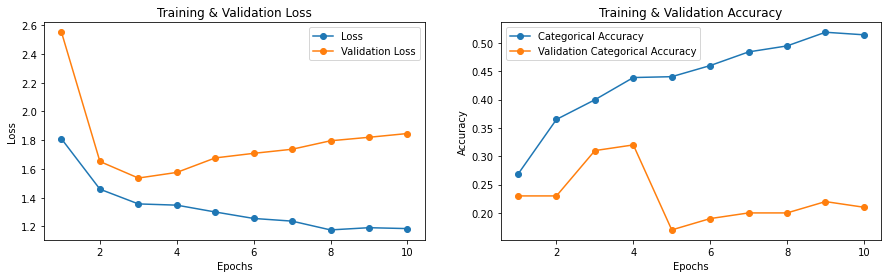

In [ ]:
plot_history(hist1)

## 2. Increase model depth

In [ ]:
hist2, model2 = train_conv_3D_model(name='model_2',
                                    batch_size = 128,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 10,           # set frame rate
                                    frame_size = (80, 80),     # set frame size
                                    conv_blocks = [32, 64, 128], # List of convolution block filters
                                    conv_filter = (3,3,3),     # set convolution filter size
                                    full_connected = [64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 10, 80, 80, 3)]   0         
                                                                 
 rescale (Rescaling)         (None, 10, 80, 80, 3)     0         
                                                                 
 conv3d_55 (Conv3D)          (None, 10, 80, 80, 32)    2624      
                                                                 
 batch_normalization_81 (Bat  (None, 10, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 activation_81 (Activation)  (None, 10, 80, 80, 32)    0         
                                                                 
 max_pooling3d_55 (MaxPoolin  (None, 5, 40, 40, 32)    0         
 g3D)                                            

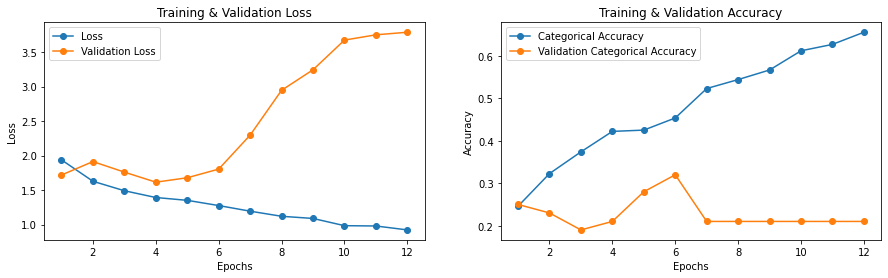

In [ ]:
plot_history(hist2)

## 3. Increase FPS to 15



In [ ]:
hist3, model3 = train_conv_3D_model(name='model_3',
                                    batch_size = 128,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 15,           # set frame rate
                                    frame_size = (80, 80),     # set frame size
                                    conv_blocks = [32, 64, 128], # List of convolution block filters
                                    conv_filter = (3,3,3),     # set convolution filter size
                                    full_connected = [128, 64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 15, 80, 80, 3)]   0         
                                                                 
 rescale (Rescaling)         (None, 15, 80, 80, 3)     0         
                                                                 
 conv3d_58 (Conv3D)          (None, 15, 80, 80, 32)    2624      
                                                                 
 batch_normalization_86 (Bat  (None, 15, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 activation_86 (Activation)  (None, 15, 80, 80, 32)    0         
                                                                 
 max_pooling3d_58 (MaxPoolin  (None, 7, 40, 40, 32)    0         
 g3D)                                            

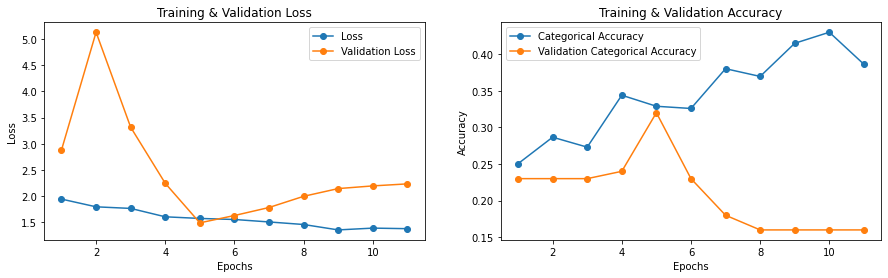

In [ ]:
plot_history(hist3)

## 4. Increase FPS to 30

batch size reduced due to ut of memory

In [ ]:
hist4, model4 = train_conv_3D_model(name='model_4',
                                    batch_size = 64,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 15,           # set frame rate
                                    frame_size = (80, 80),     # set frame size
                                    conv_blocks = [32, 64, 128], # List of convolution block filters
                                    conv_filter = (3,3,3),     # set convolution filter size
                                    full_connected = [128, 64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 15, 80, 80, 3)]   0         
                                                                 
 rescale (Rescaling)         (None, 15, 80, 80, 3)     0         
                                                                 
 conv3d_99 (Conv3D)          (None, 15, 80, 80, 32)    2624      
                                                                 
 batch_normalization_168 (Ba  (None, 15, 80, 80, 32)   128       
 tchNormalization)                                               
                                                                 
 activation_168 (Activation)  (None, 15, 80, 80, 32)   0         
                                                                 
 max_pooling3d_99 (MaxPoolin  (None, 7, 40, 40, 32)    0         
 g3D)                                            

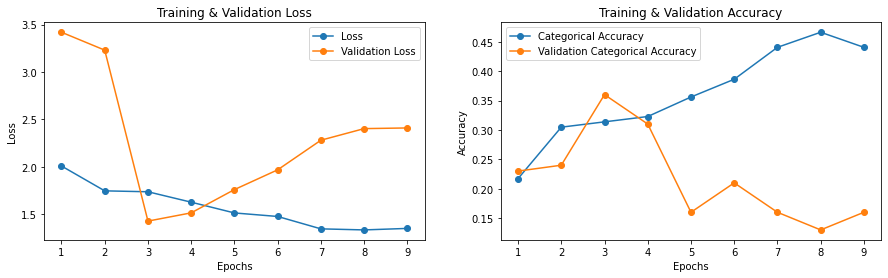

In [ ]:
plot_history(hist4)

## 5. increase input frame size to 112x112

reduce batch size, memory issues

In [ ]:
hist5, model5 = train_conv_3D_model(name='model_5',
                                    batch_size = 32,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 30,           # set frame rate
                                    frame_size = (112, 112),     # set frame size
                                    conv_blocks = [32, 64, 128], # List of convolution block filters
                                    conv_filter = (3,3,3),     # set convolution filter size
                                    full_connected = [128, 64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 30, 112, 112, 3)  0         
                             ]                                   
                                                                 
 rescale (Rescaling)         (None, 30, 112, 112, 3)   0         
                                                                 
 conv3d_102 (Conv3D)         (None, 30, 112, 112, 32)  2624      
                                                                 
 batch_normalization_174 (Ba  (None, 30, 112, 112, 32)  128      
 tchNormalization)                                               
                                                                 
 activation_174 (Activation)  (None, 30, 112, 112, 32)  0        
                                                                 
 max_pooling3d_102 (MaxPooli  (None, 15, 56, 56, 

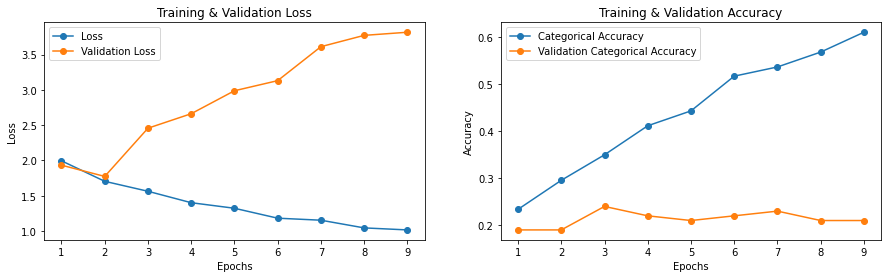

In [ ]:
plot_history(hist5)

## 6. increase input frame size to 160x160

mem issues, reduce batch

In [ ]:
hist6, model6 = train_conv_3D_model(name='model_6',
                                    batch_size = 16,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 30,           # set frame rate
                                    frame_size = (160, 160),     # set frame size
                                    conv_blocks = [32, 64, 128], # List of convolution block filters
                                    conv_filter = (3,3,3),     # set convolution filter size
                                    full_connected = [128, 64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 30, 160, 160, 3)  0         
                             ]                                   
                                                                 
 rescale (Rescaling)         (None, 30, 160, 160, 3)   0         
                                                                 
 conv3d_105 (Conv3D)         (None, 30, 160, 160, 32)  2624      
                                                                 
 batch_normalization_180 (Ba  (None, 30, 160, 160, 32)  128      
 tchNormalization)                                               
                                                                 
 activation_180 (Activation)  (None, 30, 160, 160, 32)  0        
                                                                 
 max_pooling3d_105 (MaxPooli  (None, 15, 80, 80, 

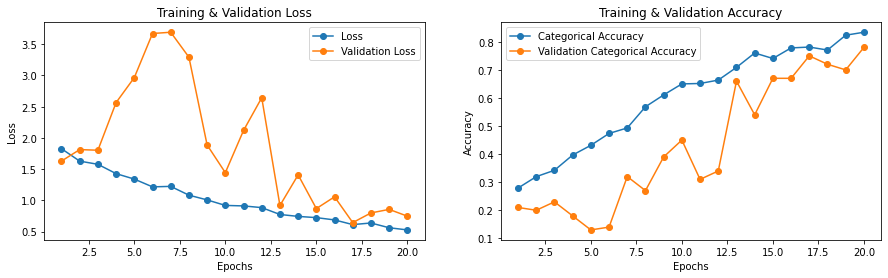

In [ ]:
plot_history(hist6)

## 7. keep frame 160x160 but reduce frame rate to 15

In [ ]:
hist7, model7 = train_conv_3D_model(name='model_7',
                                    batch_size = 32,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 15,           # set frame rate
                                    frame_size = (160, 160),     # set frame size
                                    conv_blocks = [32, 64, 128], # List of convolution block filters
                                    conv_filter = (3,3,3),     # set convolution filter size
                                    full_connected = [12, 64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 15, 160, 160, 3)  0         
                             ]                                   
                                                                 
 rescale (Rescaling)         (None, 15, 160, 160, 3)   0         
                                                                 
 conv3d_108 (Conv3D)         (None, 15, 160, 160, 32)  2624      
                                                                 
 batch_normalization_186 (Ba  (None, 15, 160, 160, 32)  128      
 tchNormalization)                                               
                                                                 
 activation_186 (Activation)  (None, 15, 160, 160, 32)  0        
                                                                 
 max_pooling3d_108 (MaxPooli  (None, 7, 80, 80, 3

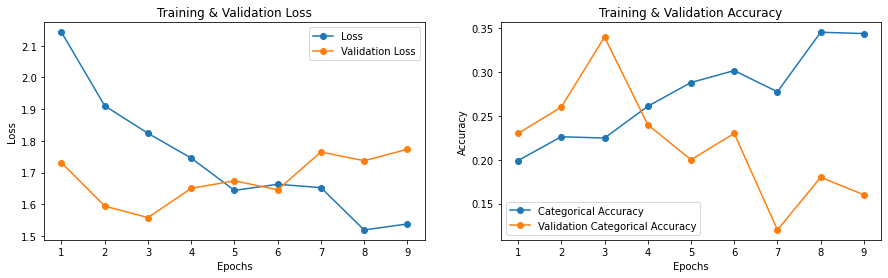

In [ ]:
plot_history(hist7)

## 8. keep frame 160x160 but reduce frame rate to 10

In [ ]:
hist8, model8 = train_conv_3D_model(name='model_8',
                                    batch_size = 64,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 10,           # set frame rate
                                    frame_size = (160, 160),     # set frame size
                                    conv_blocks = [32, 64, 128], # List of convolution block filters
                                    conv_filter = (3,3,3),     # set convolution filter size
                                    full_connected = [128, 64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 10, 160, 160, 3)  0         
                             ]                                   
                                                                 
 rescale (Rescaling)         (None, 10, 160, 160, 3)   0         
                                                                 
 conv3d_111 (Conv3D)         (None, 10, 160, 160, 32)  2624      
                                                                 
 batch_normalization_192 (Ba  (None, 10, 160, 160, 32)  128      
 tchNormalization)                                               
                                                                 
 activation_192 (Activation)  (None, 10, 160, 160, 32)  0        
                                                                 
 max_pooling3d_111 (MaxPooli  (None, 5, 80, 80, 3

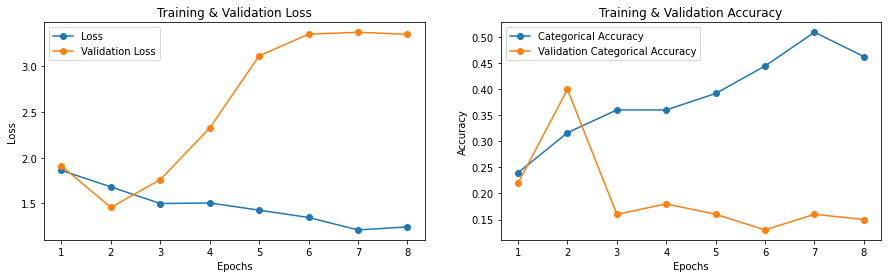

In [ ]:
plot_history(hist8)

## 9. Train very very large model

In [ ]:
hist9, model9 = train_conv_3D_model(name='model_9',
                                    batch_size = 16,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 30,           # set frame rate
                                    frame_size = (160, 160),     # set frame size
                                    conv_blocks = [32, 64, 128, 256], # List of convolution block filters
                                    conv_filter = (5,5,5),     # set convolution filter size
                                    full_connected = [256, 128, 64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 30, 160, 160, 3)  0         
                             ]                                   
                                                                 
 rescale (Rescaling)         (None, 30, 160, 160, 3)   0         
                                                                 
 conv3d_114 (Conv3D)         (None, 30, 160, 160, 32)  12032     
                                                                 
 batch_normalization_198 (Ba  (None, 30, 160, 160, 32)  128      
 tchNormalization)                                               
                                                                 
 activation_198 (Activation)  (None, 30, 160, 160, 32)  0        
                                                                 
 max_pooling3d_114 (MaxPooli  (None, 15, 80, 80, 

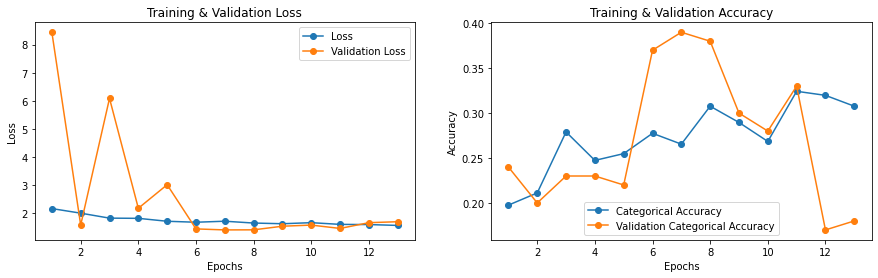

In [ ]:
plot_history(hist9)

## 10. retraining 6 for 50 epochs using updated generator with augmentaion

In [ ]:
hist10, model10 = train_conv_3D_model(name='model_10',
                                    batch_size = 16,           # set batch size for training and validation
                                    num_epochs = 50,           # Define the number of epochs for training
                                    frame_rate = 30,           # set frame rate
                                    frame_size = (160, 160),     # set frame size
                                    conv_blocks = [32, 64, 128], # List of convolution block filters
                                    conv_filter = (3,3,3),     # set convolution filter size
                                    full_connected = [128, 64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 160, 160, 3)  0         
                             ]                                   
                                                                 
 rescale (Rescaling)         (None, 30, 160, 160, 3)   0         
                                                                 
 conv3d_6 (Conv3D)           (None, 30, 160, 160, 32)  2624      
                                                                 
 batch_normalization_12 (Bat  (None, 30, 160, 160, 32)  128      
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 30, 160, 160, 32)  0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 15, 80, 80, 

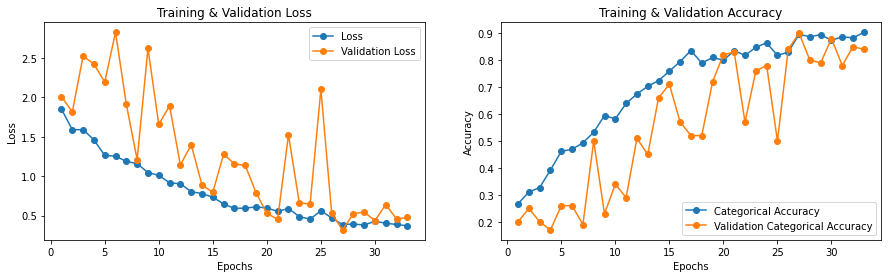

In [ ]:
plot_history(hist10)

# CNN + RNN

## Model

In [ ]:
def cnn_rnn_model(frame_rate, frame_size, conv_blocks, conv_filter, gru_layers, full_connected):


    inputs = Input(shape=(frame_rate, frame_size[0], frame_size[1], 3))

    # Rescale pixel values to range [0,1] by dividing by 255
    x = Rescaling(scale=1./255, name="rescale")(inputs)

    # Create Convolution Blocks
    for filters in conv_blocks:
        x = TimeDistributed(Conv2D(filters, conv_filter, padding='same', activation='relu'))(x)
        x = TimeDistributed(BatchNormalization())(x)
        x = TimeDistributed(MaxPooling2D())(x)
        x = Dropout(0.2)(x)

    # Flatten the feature map into a 1D vector
    x = TimeDistributed(GlobalAveragePooling2D())(x)

    # GRU Layers - Ensure only the last GRU layer has return_sequences=False
    for i, cells in enumerate(gru_layers):
        return_seq = i < len(gru_layers) - 1  # True for all but the last GRU layer
        x = GRU(cells, return_sequences=return_seq)(x)
        x = Dropout(0.2)(x)

    # Fully Connected Layer:
    for units in full_connected:
        x = Dense(units)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)

    # Output Layer:
    x = Dense(5, activation="softmax")(x)

    # Define the Model
    model = tf.keras.Model(inputs, x, name="Gesture_Detection")

    return model  # Return the created model

## Train Model

In [ ]:
def train_cnn_rnn_model(name, batch_size, num_epochs, frame_rate, frame_size, conv_blocks, conv_filter, gru_layers, full_connected):

    # Generate data
    train_generator  = generator(train_data_path, train_folders_data, batch_size=batch_size, frame_rate=frame_rate, frame_size=frame_size, verbose=-1)

    val_generator = generator(val_data_path, val_folders_data, batch_size=batch_size, frame_rate=frame_rate, frame_size=frame_size, verbose=-1)

    # Create the model instance
    model = cnn_rnn_model(frame_rate=frame_rate, frame_size=frame_size, conv_blocks=conv_blocks, conv_filter=conv_filter, gru_layers=gru_layers, full_connected=full_connected)

    # Define optimizer
    optimiser = Adam(learning_rate=0.001)

    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.summary()

    # ModelCheckpoint saves the model during training based on performance.
    checkpoint = ModelCheckpoint("/content/Gesture_Det_"+name+".keras", monitor="val_categorical_accuracy", save_best_only=True, mode="max", verbose=1)

    # EarlyStopping stops training when a monitored metric stops improving.
    earlystop = EarlyStopping( monitor="val_categorical_accuracy", patience=6, mode="max", restore_best_weights=True, verbose=1)

    # ReduceLROnPlateau is a callback that reduces the learning rate when a metric has stopped improving.
    learn_control = ReduceLROnPlateau(monitor='val_categorical_accuracy', patience=4, verbose=1, factor=0.2, min_lr=1e-7)


    num_train_sequences = len(train_folders_data)   # Calculate the number of training sequences from the training dataset
    num_val_sequences = len(val_folders_data)       # Calculate the number of validation sequences from the validation dataset
    train_batches_per_epoch = (num_train_sequences + batch_size - 1) // batch_size
                                                    # Calculate the number of batches per epoch for training
    val_batches_per_epoch = (num_val_sequences + batch_size - 1) // batch_size
                                                    # Calculate the number of batches per epoch for validation

    # Fit model
    hist = model.fit(train_generator,
          epochs=num_epochs, steps_per_epoch=train_batches_per_epoch,
          validation_data=val_generator, validation_steps=val_batches_per_epoch,
          callbacks=[ checkpoint, earlystop, learn_control],
          verbose=1
          )

    return hist, model


# 11. create small cnn-rnn model

In [35]:
hist11, model11 = train_cnn_rnn_model(name='model_11',
                                    batch_size = 16,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 15,           # set frame rate
                                    frame_size = (120, 120),     # set frame size
                                    conv_blocks = [32, 64, 128], # List of convolution block filters
                                    conv_filter = (3,3),     # set convolution filter size
                                    gru_layers = [128],
                                    full_connected = [64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 15, 120, 120, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescale (Rescaling)                  │ (None, 15, 120, 120, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_20                  │ (None, 15, 120, 120, 32)    │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_21                  │ (None, 15, 120, 120, 32)    │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_22                  │ (None, 15, 60, 60, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 15, 60, 60, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_23                  │ (None, 15, 60, 60, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_24                  │ (None, 15, 60, 60, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_25                  │ (None, 15, 30, 30, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 15, 30, 30, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_26                  │ (None, 15, 30, 30, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_27                  │ (None, 15, 30, 30, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_28                  │ (None, 15, 15, 15, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 15, 15, 15, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_29                  │ (None, 15, 128)             │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 204,101 (797.27 KB)

 Trainable params: 203,461 (794.77 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - categorical_accuracy: 0.2353 - loss: 2.1143
Epoch 1: val_categorical_accuracy improved from -inf to 0.24000, saving model to /content/Gesture_Det_model_11.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - categorical_accuracy: 0.2356 - loss: 2.1118 - val_categorical_accuracy: 0.2400 - val_loss: 1.5418 - learning_rate: 0.0010
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - categorical_accuracy: 0.3093 - loss: 1.7020
Epoch 2: val_categorical_accuracy improved from 0.24000 to 0.39000, saving model to /content/Gesture_Det_model_11.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.3103 - loss: 1.6991 - val_categorical_accuracy: 0.3900 - val_loss: 1.2825 - learning_rate: 0.0010
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - categorical_accuracy: 0.3876 - loss: 1.4294
Epoch 3: val_categorical_accuracy did not improve from 0.39000
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.3874 - loss: 1.

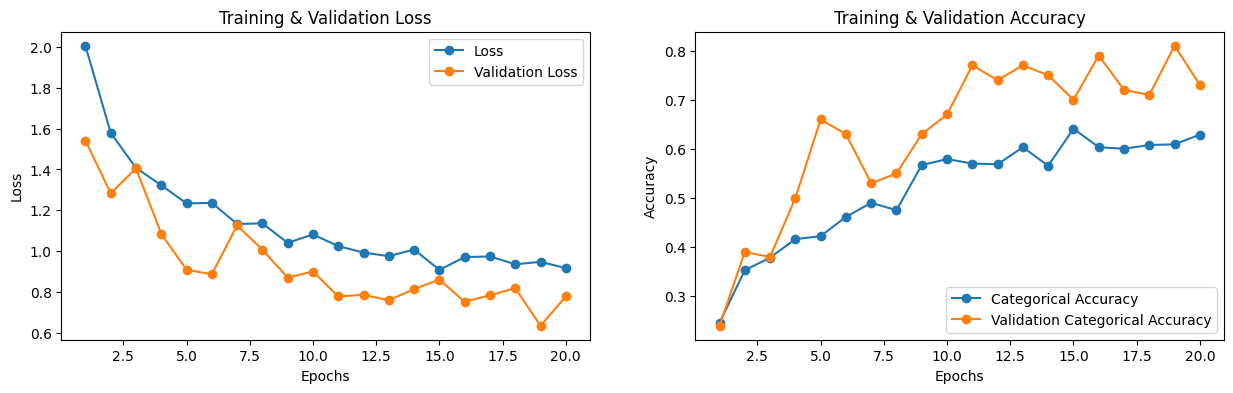

In [36]:
plot_history(hist11)

## 12. use better frome rate

In [38]:
hist12, model12 = train_cnn_rnn_model(name='model_12',
                                    batch_size = 8,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 30,           # set frame rate
                                    frame_size = (120, 120),     # set frame size
                                    conv_blocks = [32, 64, 128], # List of convolution block filters
                                    conv_filter = (3,3),     # set convolution filter size
                                    gru_layers = [128, 128],
                                    full_connected = [64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 30, 120, 120, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescale (Rescaling)                  │ (None, 30, 120, 120, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_40                  │ (None, 30, 120, 120, 32)    │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_41                  │ (None, 30, 120, 120, 32)    │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_42                  │ (None, 30, 60, 60, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 30, 60, 60, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_43                  │ (None, 30, 60, 60, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_44                  │ (None, 30, 60, 60, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_45                  │ (None, 30, 30, 30, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 30, 30, 30, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_46                  │ (None, 30, 30, 30, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_47                  │ (None, 30, 30, 30, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_48                  │ (None, 30, 15, 15, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 30, 15, 15, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_49                  │ (None, 30, 128)             │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 30, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 303,173 (1.16 MB)

 Trainable params: 302,533 (1.15 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/Gesture_Detection_1/time_distributed_42_1/strided_slice_24/StridedSliceGrad defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-38-40dccdb0e07a>", line 1, in <cell line: 0>

  File "<ipython-input-31-ac8622671c11>", line 35, in train_cnn_rnn_model

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 77, in train_step

OOM when allocating tensor with shape[30,8,120,120,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/Gesture_Detection_1/time_distributed_42_1/strided_slice_24/StridedSliceGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_137350]

In [ ]:
plot_history(hist12)

# CNN + RNN + TL

## Train model

In [36]:
def train_cnn_rnn_model_with_TL(name, batch_size, num_epochs, frame_rate, frame_size, model):

    # Generate data
    train_generator  = generator(train_data_path, train_folders_data, batch_size=batch_size, frame_rate=frame_rate, frame_size=frame_size, verbose=-1)

    val_generator = generator(val_data_path, val_folders_data, batch_size=batch_size, frame_rate=frame_rate, frame_size=frame_size, verbose=-1)

    # Define optimizer
    optimiser = Adam(learning_rate=0.001)

    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.summary()

    # ModelCheckpoint saves the model during training based on performance.
    checkpoint = ModelCheckpoint("/content/Gesture_Det_"+name+".keras", monitor="val_categorical_accuracy", save_best_only=True, mode="max", verbose=1)

    # EarlyStopping stops training when a monitored metric stops improving.
    earlystop = EarlyStopping( monitor="val_categorical_accuracy", patience=6, mode="max", restore_best_weights=True, verbose=1)

    # ReduceLROnPlateau is a callback that reduces the learning rate when a metric has stopped improving.
    learn_control = ReduceLROnPlateau(monitor='val_categorical_accuracy', patience=4, verbose=1, factor=0.2, min_lr=1e-7)


    num_train_sequences = len(train_folders_data)   # Calculate the number of training sequences from the training dataset
    num_val_sequences = len(val_folders_data)       # Calculate the number of validation sequences from the validation dataset
    train_batches_per_epoch = (num_train_sequences + batch_size - 1) // batch_size
                                                    # Calculate the number of batches per epoch for training
    val_batches_per_epoch = (num_val_sequences + batch_size - 1) // batch_size
                                                    # Calculate the number of batches per epoch for validation

    # Fit model
    hist = model.fit(train_generator,
          epochs=num_epochs, steps_per_epoch=train_batches_per_epoch,
          validation_data=val_generator, validation_steps=val_batches_per_epoch,
          callbacks=[ checkpoint, earlystop, learn_control],
          verbose=1
          )

    return hist, model


In [37]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc.

from keras.applications import mobilenet

In [38]:
def create_cnn_rnn_tf_model(gru_cells, dense_neurons, dropout, train_base_model=False):

    model = Sequential()

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(30,120,120,3)))

    for layer in model.layers:
            layer.trainable = train_base_model

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(gru_cells))
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(5, activation='softmax'))

    return model

In [39]:
hist14, model14 = train_cnn_rnn_model_with_TL(name='model_14',
                                              batch_size = 16,           # set batch size for training and validation
                                              num_epochs = 20,           # Define the number of epochs for training
                                              frame_rate = 30,           # set frame rate
                                              frame_size = (120, 120),     # set frame size
                                              model=create_cnn_rnn_tf_model(gru_cells=128, dense_neurons=128, dropout=0.25, train_base_model=False)
                                              )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 30, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 30, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 128)              

2025-02-28 17:32:30.198449: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


42/42 [==============================] - ETA: 0s - loss: 1.5504 - categorical_accuracy: 0.3454
Epoch 00001: val_categorical_accuracy improved from -inf to 0.37000, saving model to /content/Gesture_Det_model_14.keras
42/42 [==============================] - 47s 998ms/step - loss: 1.5504 - categorical_accuracy: 0.3454 - val_loss: 1.4185 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 1.0562 - categorical_accuracy: 0.5837
Epoch 00002: val_categorical_accuracy improved from 0.37000 to 0.50000, saving model to /content/Gesture_Det_model_14.keras
42/42 [==============================] - 39s 959ms/step - loss: 1.0562 - categorical_accuracy: 0.5837 - val_loss: 1.2633 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 0.6635 - categorical_accuracy: 0.7753
Epoch 00003: val_categorical_accuracy did not improve from 0.50000
42/42 [==============================] - 40

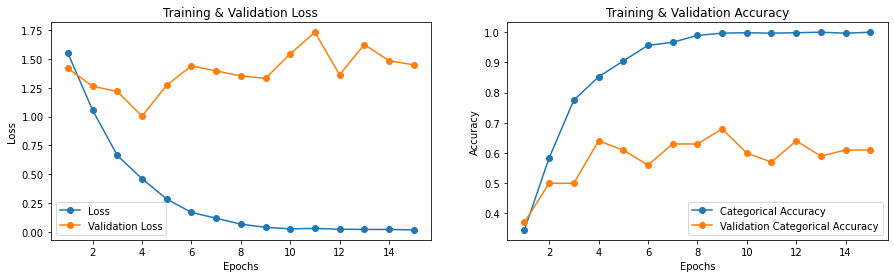

In [ ]:
plot_history(hist14)

model is overfitting, increasing dropout

In [42]:
hist15, model15 = train_cnn_rnn_model_with_TL(name='model_15',
                                              batch_size = 16,           # set batch size for training and validation
                                              num_epochs = 20,           # Define the number of epochs for training
                                              frame_rate = 30,           # set frame rate
                                              frame_size = (120, 120),     # set frame size
                                              model=create_cnn_rnn_tf_model(gru_cells=128, dense_neurons=128, dropout=0.5, train_base_model=False)
                                              )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 30, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 30, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 30, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 1024)         0         
 stributed)                                                      
                                                                 
 gru_3 (GRU)                 (None, 128)              

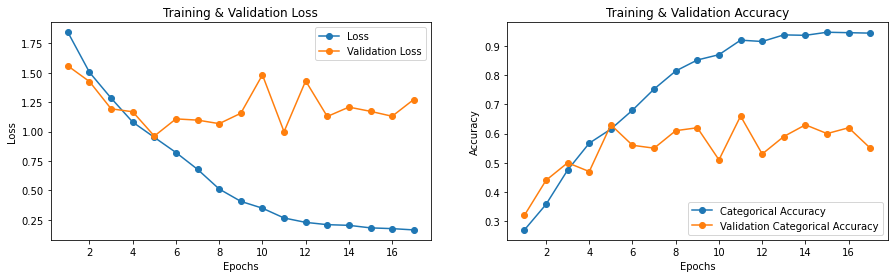

In [ ]:
plot_history(hist15)

turning on training for base model

In [44]:
hist16, model16 = train_cnn_rnn_model_with_TL(name='model_16',
                                              batch_size = 16,           # set batch size for training and validation
                                              num_epochs = 50,           # Define the number of epochs for training
                                              frame_rate = 30,           # set frame rate
                                              frame_size = (120, 120),     # set frame size
                                              model=create_cnn_rnn_tf_model(gru_cells=128, dense_neurons=128, dropout=0.25, train_base_model=True)
                                              )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 30, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 1024)         0         
 stributed)                                                      
                                                                 
 gru_4 (GRU)                 (None, 128)              

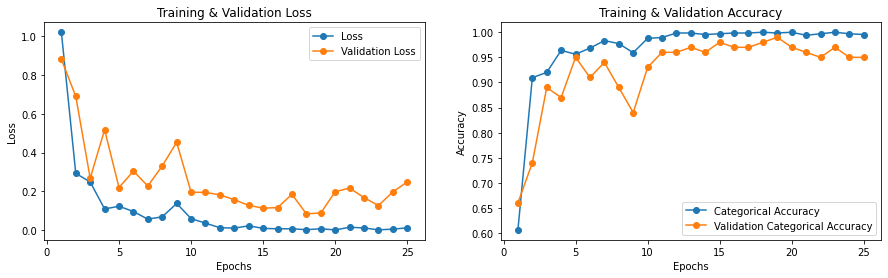

In [ ]:
plot_history(hist16)

efficient net

In [49]:
from tensorflow.keras.applications import EfficientNetB0

In [50]:
def create_cnn_rnn_et_model(gru_cells, dense_neurons, dropout, train_base_model=False):

    model = Sequential()

    efficientnet_transfer = EfficientNetB0(weights='imagenet', include_top=False)
    model.add(TimeDistributed(efficientnet_transfer,input_shape=(30,120,120,3)))

    for layer in model.layers:
            layer.trainable = train_base_model

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(gru_cells))
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(5, activation='softmax'))

    return model

In [51]:
hist17, model17 = train_cnn_rnn_model_with_TL(name='model_17',
                                              batch_size = 16,           # set batch size for training and validation
                                              num_epochs = 50,           # Define the number of epochs for training
                                              frame_rate = 30,           # set frame rate
                                              frame_size = (120, 120),     # set frame size
                                              model=create_cnn_rnn_et_model(gru_cells=128, dense_neurons=128, dropout=0.25, train_base_model=True)
                                              )

16719872/16705208 [==============================] - 2s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 30, 3, 3, 1280)   4049571   
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 30, 3, 3, 1280)   5120      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 30, 1, 1, 1280)   0         
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 30, 1280)         0         
 stributed)                                                      
                                                       

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


42/42 [==============================] - 57s 1s/step - loss: 0.9755 - categorical_accuracy: 0.6139 - val_loss: 1.1693 - val_categorical_accuracy: 0.6200 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - ETA: 0s - loss: 0.2236 - categorical_accuracy: 0.9140
Epoch 00002: val_categorical_accuracy improved from 0.62000 to 0.89000, saving model to /content/Gesture_Det_model_17.keras
42/42 [==============================] - 43s 1s/step - loss: 0.2236 - categorical_accuracy: 0.9140 - val_loss: 0.4189 - val_categorical_accuracy: 0.8900 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 0.1227 - categorical_accuracy: 0.9608
Epoch 00003: val_categorical_accuracy did not improve from 0.89000
42/42 [==============================] - 43s 1s/step - loss: 0.1227 - categorical_accuracy: 0.9608 - val_loss: 0.3085 - val_categorical_accuracy: 0.8600 - lr: 0.0010
Epoch 4/50
42/42 [==============================] - ETA: 0s - loss: 0.0742 - categorical_accuracy: 

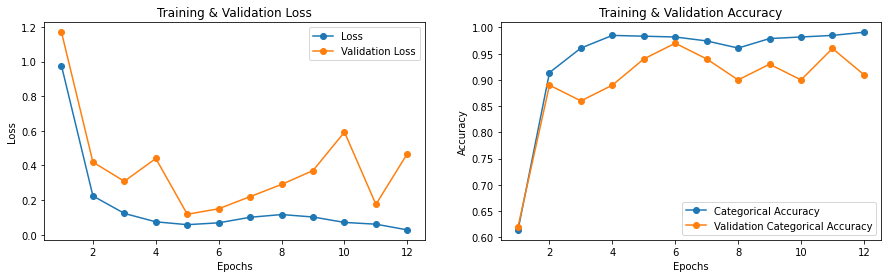

In [52]:
plot_history(hist17)

I3D

In [ ]:
from tensorflow.keras.applications import InceptionV3

In [ ]:
def create_cnn_rnn_i3d_model(gru_cells, dense_neurons, dropout, train_base_model=False):

    model = Sequential()

    efficientnet_transfer = InceptionV3(weights='imagenet', include_top=False)
    model.add(TimeDistributed(efficientnet_transfer,input_shape=(30,120,120,3)))

    for layer in model.layers:
            layer.trainable = train_base_model

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(gru_cells))
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(5, activation='softmax'))

    return model